In [53]:
import numpy as np
import mrcfile 
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F 
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta


from scipy.ndimage import gaussian_filter

from PIL import Image 
from tqdm import tqdm

In [2]:
def generate_data(K,std=0.1,std_xy=0.16,n=8):
    #img = np.array(Image.open("image.png").convert("L").resize((n,n)))
    #img = torch.tensor(np.array(img),dtype=torch.float32)
    #img = (img - img.min())/(img.max() - img.min())
    img = np.zeros((8,8))
    img[2:4,2:3] = 1
    img[5:7,2:3] = 1
    img[4:6,5:7] = 1
    img = torch.tensor(img,dtype=torch.float32)

    thetas = (2 * torch.pi) * torch.rand(size=(K,))
    normal_dist = MultivariateNormal(loc=torch.zeros(2), 
                                     covariance_matrix=std_xy * torch.eye(2))
    beta_dist = Beta(2, 5)
    translations = normal_dist.sample((K,))
    scales = 5*beta_dist.sample((K,))

    transformations = torch.zeros((K, 2, 3))
    transformations[:, 0, 0] = torch.cos(thetas)
    transformations[:, 0, 1] = -torch.sin(thetas)
    transformations[:, 1, 0] = torch.sin(thetas)
    transformations[:, 1, 1] = torch.cos(thetas)
    transformations[:, :, 2] = 2*translations/n

    grid = F.affine_grid(transformations, size=(K, 1, n, n), align_corners=False)
    data = F.grid_sample(img.expand(K, 1, n, n), grid, align_corners=False).squeeze(1)
    data = data * scales.view(K,1,1) + torch.normal(mean=0,std=std,size=(K,n,n))

    data = data.numpy()
    return data

@torch.no_grad()
def expectation_maximization(device,A, data, std, std_xy, K=10000):
    n = A.shape[0]    
    batch_size = K // 10
    num_batch = K // batch_size

    normal_dist = MultivariateNormal(loc=torch.zeros(2).to(device), 
                                     covariance_matrix=std_xy * torch.eye(2).to(device))
    uniform_dist = Uniform(0,2*torch.pi)
    beta_dist = Beta(torch.tensor(2.0).to(device), torch.tensor(5.0).to(device))

    A_t = torch.zeros_like(A,dtype=torch.float32).to(device)
    std_t = torch.tensor(0,dtype=torch.float32).to(device)
    stdxy_t = torch.tensor(0,dtype=torch.float32).to(device)
    Z = torch.tensor(0, dtype=torch.float32).to(device)
    for i in tqdm(range(data.shape[0])):
        X = data[i]

        integral = torch.zeros_like(A_t,dtype=torch.float32)
        std_batch = torch.tensor(0,dtype=torch.float32).to(device) 
        stdxy_batch = torch.tensor(0,dtype=torch.float32).to(device)
        Z_batch = torch.tensor(0, dtype=torch.float32).to(device)

        for _ in range(num_batch):
            thetas = uniform_dist.sample((batch_size,)).to(device)
            translations = normal_dist.sample((batch_size,)).to(device)
            scales = beta_dist.sample((batch_size,)).to(device)
            

            thetas_logits = uniform_dist.log_prob(thetas).to(device)
            translations_logits = normal_dist.log_prob(translations).to(device)
            scales_logits = beta_dist.log_prob(scales/5.0).to(device) - torch.log(torch.tensor(5.0))
            #scales_logits = beta_dist.log_prob(scales).to(device)

            scales = 5.0*scales

            transformations = torch.zeros((batch_size, 2, 3)).to(device)
            transformations[:, 0, 0] = torch.cos(thetas)
            transformations[:, 0, 1] = -torch.sin(thetas)
            transformations[:, 1, 0] = torch.sin(thetas)
            transformations[:, 1, 1] = torch.cos(thetas)
            transformations[:, :, 2] = 2*translations / n # PyTorch assumes translations are in [-1,1]

            grid = F.affine_grid(transformations, size=(batch_size, 1, n, n), align_corners=False)
            A_psi = F.grid_sample(A.expand(batch_size, 1, n, n), grid, align_corners=False).squeeze(1) * (scales.view(-1,1,1))

            inv_rotations = transformations[...,:2].permute(0,2,1)
            inv_t = -torch.bmm(inv_rotations,transformations[...,2:])
            inv_trans = torch.cat([inv_rotations,inv_t],dim=-1)
            inv_grid = F.affine_grid(inv_trans,size=(batch_size,1,n,n), align_corners=False) 

            X_psi = F.grid_sample(X.expand(batch_size, 1, n, n) , inv_grid, align_corners=False).squeeze(1) / scales.view(-1,1,1)

            X_log_density = -(torch.norm(X - A_psi,dim=(1,2))) ** 2 / (2*std ** 2)
            X_log_density = X_log_density - torch.logsumexp(X_log_density,0)

            psi_log_density = thetas_logits + translations_logits + scales_logits

            w = torch.exp(X_log_density + psi_log_density)
            w /= w.sum()

            Z_batch += (w * (scales**2)).sum()
            std_batch += ( w.view(batch_size,1,1) * scales**2 * (torch.norm(X_psi - A,dim=(1,2))) ** 2 ).sum()
            stdxy_batch += (w.view(batch_size,1,1) * (torch.norm(translations,dim=1)**2)).sum()
            integral += (w.view(batch_size, 1, 1) * X_psi * (scales**2).view(batch_size,1,1)).sum(dim=0)
        A_t += integral/K
        std_t +=  std_batch / K
        stdxy_t +=  stdxy_batch/K   
        Z += Z_batch/K
    std_t /= (n**2)
    std_t /= data.shape[0]
    std_t = std_t ** 0.5
    stdxy_t /= 2*data.shape[0]
    stdxy_t = stdxy_t ** 0.5
    print(f"Updated noise variance estimation: {std_t}")
    print(f"Updated translations variance estimation: {stdxy_t}")
    A_t = A_t/Z
    return A_t, std_t, stdxy_t

    

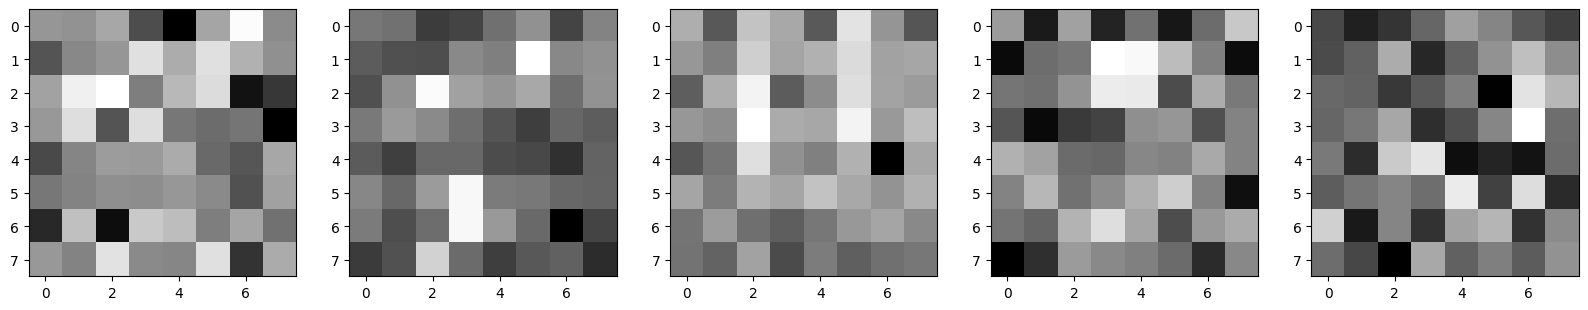

In [3]:
data = generate_data(2000,1,0.16)
fig, ax = plt.subplots(1,5,figsize=(20,8))

for i in range(5):
    ax[i].imshow(data[np.random.randint(0,800)],cmap='gray')

In [35]:
device = 'cuda'
std = torch.tensor(1).to(device)    
std_xy = torch.tensor(0.16).to(device)

img = np.zeros((8,8))
img[2:4,2:3] = 1
img[5:7,2:3] = 1
img[4:6,5:7] = 1

A = torch.tensor(img,dtype=torch.float32).to(device)
X = torch.tensor(data).type(torch.float32).to(device)

100%|██████████| 2000/2000 [01:31<00:00, 21.76it/s]


Updated noise variance estimation: 0.9878069758415222
Updated translations variance estimation: 0.39994481205940247


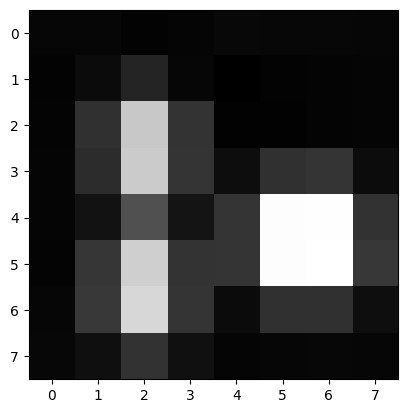

In [36]:
A, std, std_xy = expectation_maximization(device, A, X,std, std_xy)
A_np = A.cpu().numpy()
plt.imshow(A_np,cmap='gray');

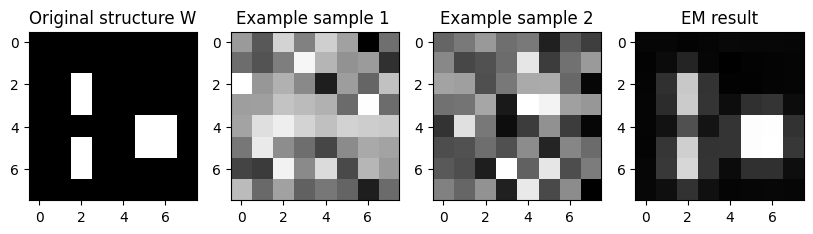

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(10,5))


      
ax[0].imshow(img,cmap='gray')
ax[0].set_title("Original structure W")
ax[1].imshow(data[np.random.randint(0,800)],cmap='gray')
ax[1].set_title("Example sample 1 ")
ax[2].imshow(data[np.random.randint(0,800)],cmap='gray')
ax[2].set_title("Example sample 2")
ax[3].imshow(A_np,cmap='gray')
ax[3].set_title("EM result");

In [46]:
w = torch.tensor(img,dtype=torch.float32).to(device)
error = torch.norm(w - A)**2 / (2000 * 64)

In [48]:
error.item()

1.3414032764558215e-05

In [82]:
std_xy = torch.tensor(0.16).to(device)
A = torch.tensor(img,dtype=torch.float32).to(device)
w = torch.tensor(img,dtype=torch.float32).to(device)
errors = []
for SNR in [0.1,0.5,1,10,100]:
    std = torch.tensor(np.mean(img)/SNR)
    data = generate_data(2000,std,0.16)
    std = torch.tensor(std).to(device)  

    X = torch.tensor(data).type(torch.float32).to(device) 
    A, std, std_xy = expectation_maximization(device, A, X,std, std_xy)
    error = torch.norm(w - A)**2 / (2000 * 64)
    errors.append(error.item())

/tmp/ipykernel_1799301/903097857.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).to(device)
100%|██████████| 2000/2000 [01:10<00:00, 28.34it/s]


Updated noise variance estimation: 0.9881662130355835
Updated translations variance estimation: 0.3999914228916168


100%|██████████| 2000/2000 [01:08<00:00, 29.13it/s]


Updated noise variance estimation: 0.46040457487106323
Updated translations variance estimation: 0.6324310302734375


100%|██████████| 2000/2000 [01:07<00:00, 29.62it/s]


Updated noise variance estimation: 0.41618236899375916
Updated translations variance estimation: 0.7951726317405701


100%|██████████| 2000/2000 [01:07<00:00, 29.84it/s]


Updated noise variance estimation: 0.3947424590587616
Updated translations variance estimation: 0.8918095827102661


100%|██████████| 2000/2000 [01:08<00:00, 29.34it/s]

Updated noise variance estimation: 0.38792744278907776
Updated translations variance estimation: 0.9442299604415894


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

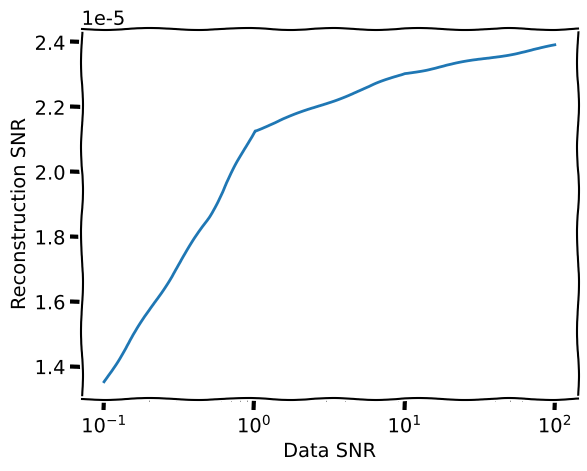

In [92]:
plt.plot([0.1,0.5,1,10,100],errors);
plt.xlabel("Data SNR")
plt.ylabel("Reconstruction SNR")
plt.xscale('log')
plt.xkcd()

In [ ]:
std_xy = torch.tensor(0.16).to(device)
std = torch.tensor(10).to(device)
w = torch.tensor(img,dtype=torch.float32).to(device)
errors1 = []
init = gaussian_filter(img,sigma=2)
for size in [100,500,1000,2000]:
    data = generate_data(size,10,0.16)
    A = torch.tensor(init,dtype=torch.float32).to(device)
    X = torch.tensor(data).type(torch.float32).to(device) 
    A, std, std_xy = expectation_maximization(device, A, X,std, std_xy)
    error = torch.norm(w - A)**2 / (2000 * 64)
    errors1.append(error.item())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Updated noise variance estimation: 6.225464344024658
Updated translations variance estimation: 0.3999041020870209


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Updated noise variance estimation: 6.150585174560547
Updated translations variance estimation: 0.6323965787887573


100%|██████████| 1000/1000 [00:40<00:00, 24.75it/s]


Updated noise variance estimation: 6.0529465675354
Updated translations variance estimation: 0.7953221201896667


100%|██████████| 2000/2000 [01:19<00:00, 25.08it/s]

Updated noise variance estimation: 6.011289119720459
Updated translations variance estimation: 0.8919292688369751


In [71]:
plt.rcdefaults()

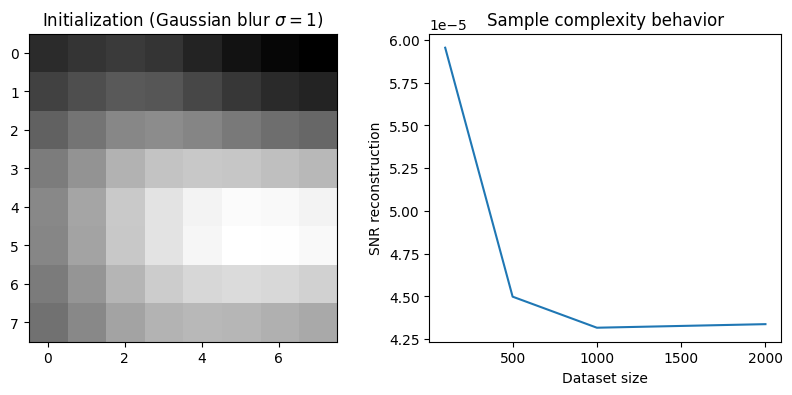

In [80]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(init,cmap='gray')
ax[0].set_title("Initialization (Gaussian blur $\sigma=1$)")
ax[1].plot([100,500,1000,2000],errors1)
ax[1].set_title("Sample complexity behavior")
ax[1].set_xlabel("Dataset size")
ax[1].set_ylabel("SNR reconstruction");